Word embedding -> 2 dimension -> 5 features

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange, tqdm

import time
import pandas as pd
import os

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import nltk
import csv
from nltk.corpus import words

from trainer import BaseTrainer
from model import Config, Model
from dm import DataManager

In [2]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
elif torch.backends.mps.is_available():
  DEVICE = 'mps'
else:
  DEVICE = 'cpu'
DEVICE = torch.device(DEVICE)

In [12]:
# Download the words corpus if not already downloaded
nltk.download('words', quiet=True)

# Get the list of English words
english_words = words.words()

# Define prefixes and suffixes
prefixes = ['un', 're']
suffixes = ['able', 'ful', 'ness']

# Function to categorize a word
def categorize_word(word):
    prefix_match = next((prefix for prefix in prefixes if word.startswith(prefix)), None)
    suffix_match = next((suffix for suffix in suffixes if word.endswith(suffix)), None)
    
    if prefix_match and suffix_match:
        return [prefix_match, suffix_match]
    elif prefix_match:
        return prefix_match
    elif suffix_match:
        return suffix_match
    else:
        return None

# Process words and create dataset
dataset = []
for word in english_words:
    category = categorize_word(word)
    if category:
        dataset.append([word, category])

# Save to CSV
with open('word_affixes_dataset.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['word', 'category'])  # Header
    writer.writerows(dataset)

print(f"Dataset created with {len(dataset)} words.")

Dataset created with 28611 words.


In [13]:
dm = DataManager()
dm.read_csv_data('word_affixes_dataset.csv')
dm.manipulate_data()
dm.train_valid_test_split()


Sample words and corresponding categories (non-dual)... 

['abandonable', 'abasedness', 'abashedness', 'abatable', 'abdicable']
['able', 'ness', 'ness', 'able', 'able']

Sample dual words...

['reachable', 'reactionariness', 'reactiveness', 'readable', 'readableness']
[[3, 0], [3, 2], [3, 2], [3, 0], [3, 2]]


In [14]:
for x, y in dm.train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 8]) torch.Size([64])


In [15]:
config = Config(
    vocab_size=dm.vocab_size,
    word2idx=dm.word2idx,
    n_features=dm.num_classes,
    n_hidden=2,
    run_mode='scratch',
)

model = Model(config).to(DEVICE)

In [30]:
path_name = "".join(prefixes + suffixes)

In [8]:
model.load_state_dict(torch.load(f"./checkpoints/{path_name}.pth"))

/var/folders/kx/przxh3f53rsf_n6jv56kzhdc0000gn/T/ipykernel_62186/3620947320.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./checkpoi

<All keys matched successfully>

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = BaseTrainer(model=model, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader, device=DEVICE)
trainer.fit(num_epochs=100)

Epoch 1/100
324/324 - train_loss: 1.3351 - train_accuracy: 47.6347%                 - val_loss: 0.0426 - val_accuracy: 72.6816%
Epoch 2/100
324/324 - train_loss: 0.7246 - train_accuracy: 79.1012%                 - val_loss: 0.0251 - val_accuracy: 83.6167%
Epoch 3/100
324/324 - train_loss: 0.4504 - train_accuracy: 84.0638%                 - val_loss: 0.0159 - val_accuracy: 85.4328%
Epoch 4/100
324/324 - train_loss: 0.2765 - train_accuracy: 87.1225%                 - val_loss: 0.0110 - val_accuracy: 88.8331%
Epoch 5/100
324/324 - train_loss: 0.1542 - train_accuracy: 94.9263%                 - val_loss: 0.0042 - val_accuracy: 95.5564%
Epoch 6/100
324/324 - train_loss: 0.0738 - train_accuracy: 97.1974%                 - val_loss: 0.0026 - val_accuracy: 97.6816%
Epoch 7/100
324/324 - train_loss: 0.0364 - train_accuracy: 99.4830%                 - val_loss: 0.0030 - val_accuracy: 97.8362%
Epoch 8/100
324/324 - train_loss: 0.0217 - train_accuracy: 99.5458%                 - val_loss: 0.0039 -

In [17]:
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
torch.save(model.state_dict(), f"checkpoints/{path_name}.pth")

In [18]:
test_loss, test_accuracy = trainer.evaluate(dm.test_loader)
print(f"test_loss: {test_loss:.4f} - test_accuracy: {test_accuracy*100:.4f}%")

test_loss: 0.0000 - test_accuracy: 97.7185%


In [19]:
dual_loss, dual_accuracy = trainer.evaluate_dual_labels(dm.dual_loader)
print(f"dual_loss: {dual_loss:.4f} - dual_accuracy: {dual_accuracy*100:.4f}%")

dual_loss: 1229.9765 - dual_accuracy: 95.8060%


In [26]:
def plot_intro_diagram(model, hiddens=None):
  from matplotlib import colors  as mcolors
  from matplotlib import collections  as mc
  cfg = model.config
  W = model.W.cpu().detach()
  N = len(W[:,0])
  sel = range(1)
  # plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(model.importance[0].cpu().numpy()))
  plt.rcParams['figure.dpi'] = 200
  fig, ax = plt.subplots(1,len(sel), figsize=(2*len(sel),2))
  colors = [mcolors.to_rgba(c)
        for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
  ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
  ax.set_aspect('equal')
  ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))

  if hiddens is not None:
    activation = hiddens.cpu().detach().numpy()
    ax.scatter(activation[0, 0], activation[0, 1], c='black', s=100)
    
    ax.add_collection(mc.LineCollection([[(0, 0), (activation[0, 0], activation[0, 1])]], 
                                        colors=['black'], 
                                        linewidths=2, 
                                        linestyle='--'))

  z = 5
  ax.set_facecolor('#FCFBF8')
  ax.set_xlim((-z,z))
  ax.set_ylim((-z,z))
  ax.tick_params(left = True, right = False , labelleft = False ,
              labelbottom = False, bottom = True)
  for spine in ['top', 'right']:
      ax.spines[spine].set_visible(False)
  for spine in ['bottom','left']:
      ax.spines[spine].set_position('center')
  plt.show()

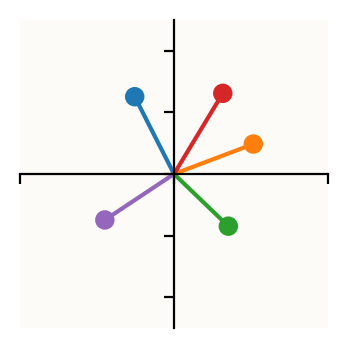

In [27]:
plot_intro_diagram(model)

In [20]:
def get_activation_from_word(word):
    tokens = dm.tokenize_data(word).to(DEVICE)
    outputs, hidden = model.forward(tokens.unsqueeze(0), return_hidden=True)
    _, predicted = torch.max(outputs.data, 1)
    return predicted, hidden

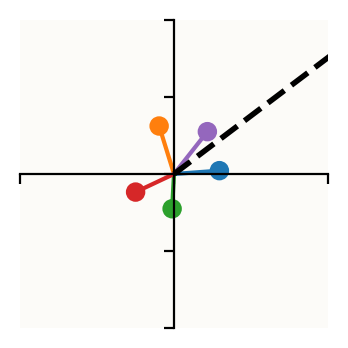

actual: un, predicted: un


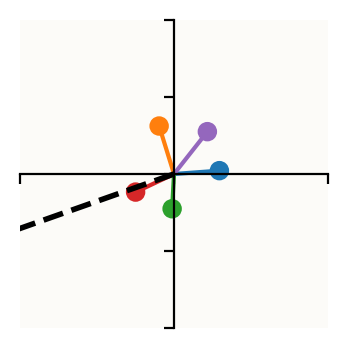

actual: re, predicted: re


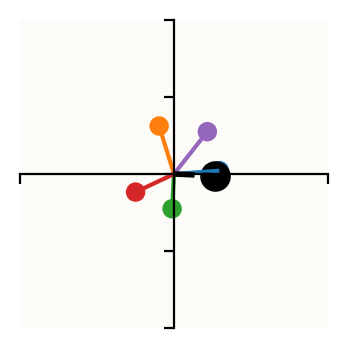

actual: able, predicted: able


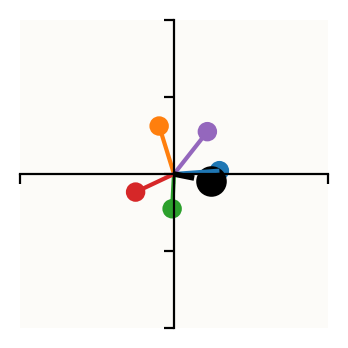

actual: ful, predicted: able


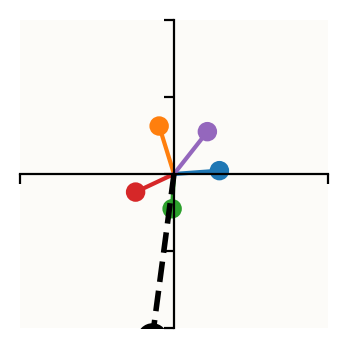

actual: ness, predicted: ness


In [21]:
for affix in (prefixes + suffixes):
    out, acts = get_activation_from_word(affix)
    plot_intro_diagram(model, acts)
    print(f"actual: {affix}, predicted: {dm.str_classes[out]}")

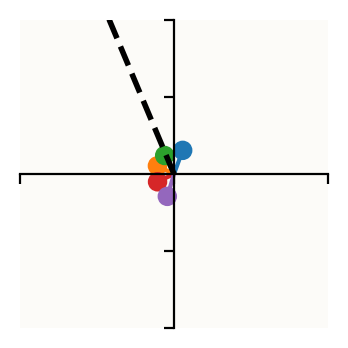

inter


In [31]:
out, acts = get_activation_from_word("interpret")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

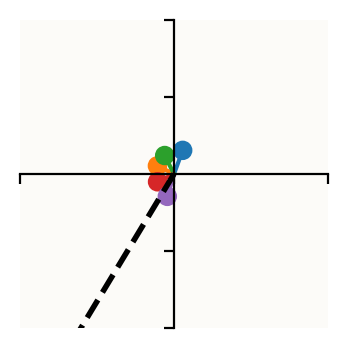

un


In [23]:
out, acts = get_activation_from_word("unsatisfied")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

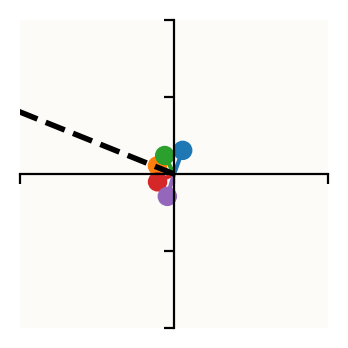

anti


In [21]:
out, acts = get_activation_from_word("antimatter")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

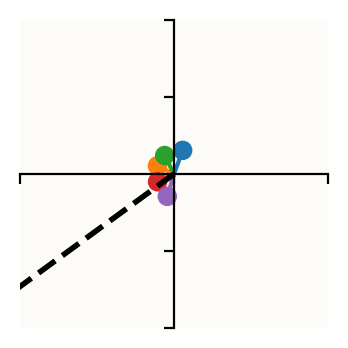

un


In [14]:
out, acts = get_activation_from_word("un")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

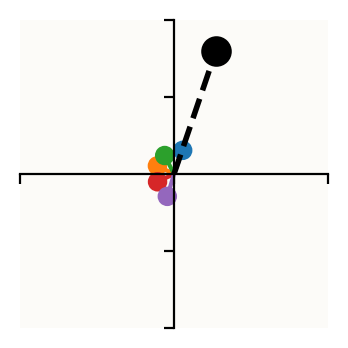

able


In [16]:
out, acts = get_activation_from_word("able")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

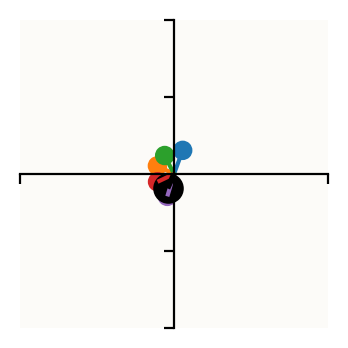

un


In [30]:
out, acts = get_activation_from_word("unless")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

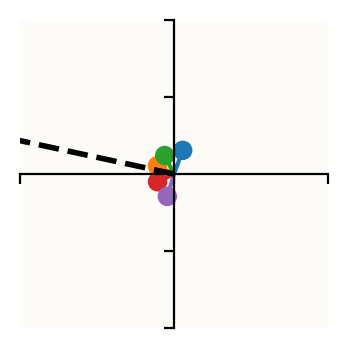

anti


In [20]:
out, acts = get_activation_from_word("fierceless")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

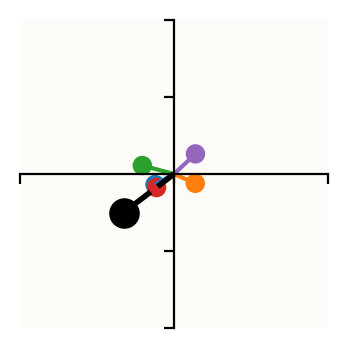

ing


In [74]:
out, acts = get_activation_from_word("ing")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

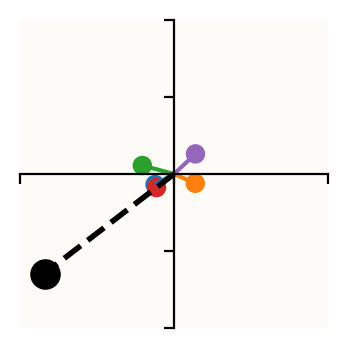

tion


In [75]:
out, acts = get_activation_from_word("tion")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

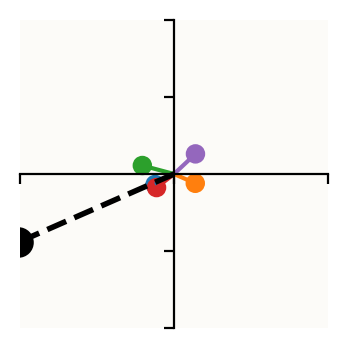

re


In [59]:
out, acts = get_activation_from_word("reinvent")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

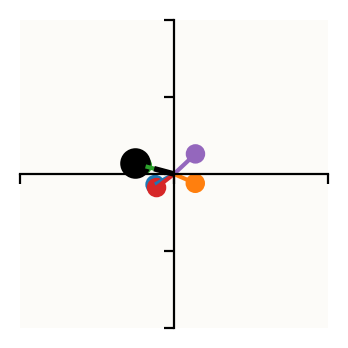

re


In [60]:
out, acts = get_activation_from_word("redo")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

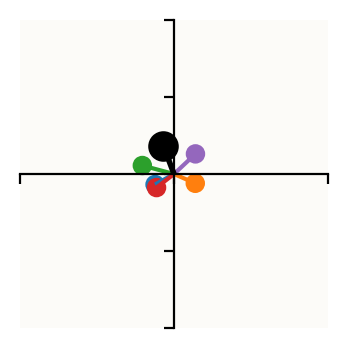

re


In [61]:
out, acts = get_activation_from_word("respond")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

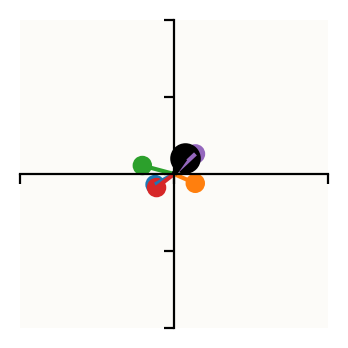

ing


In [62]:
out, acts = get_activation_from_word("replicate")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

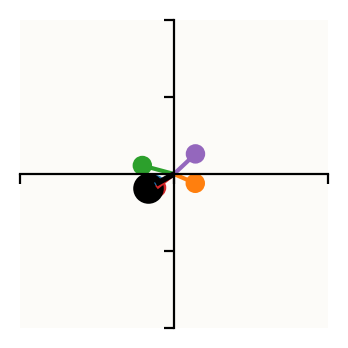

ing


In [63]:
out, acts = get_activation_from_word("something")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

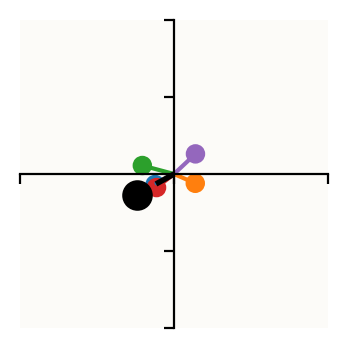

ing


In [64]:
out, acts = get_activation_from_word("anything")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

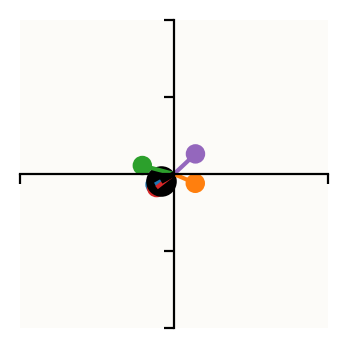

ing


In [65]:
out, acts = get_activation_from_word("doing")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

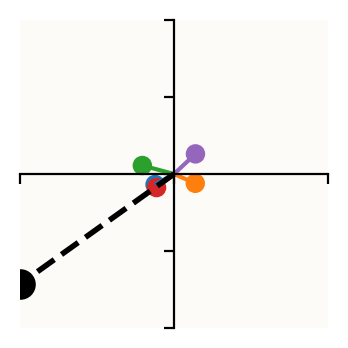

tion


In [66]:
out, acts = get_activation_from_word("lactation")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

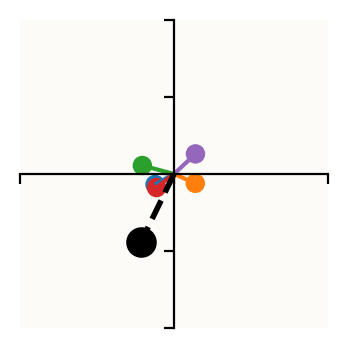

tion


In [67]:
out, acts = get_activation_from_word("nation")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

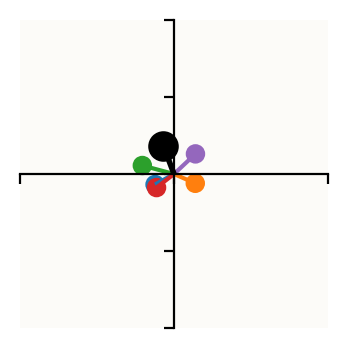

re


In [68]:
out, acts = get_activation_from_word("respond")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

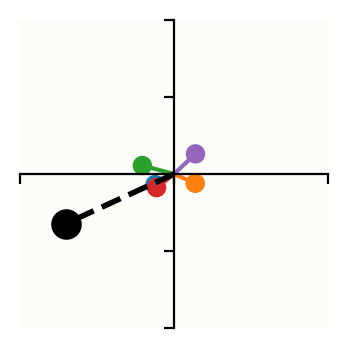

re


In [69]:
out, acts = get_activation_from_word("replay")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

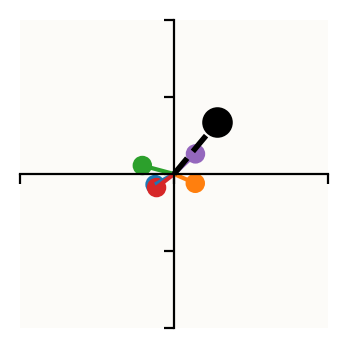

un


In [70]:
out, acts = get_activation_from_word("uncanny")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

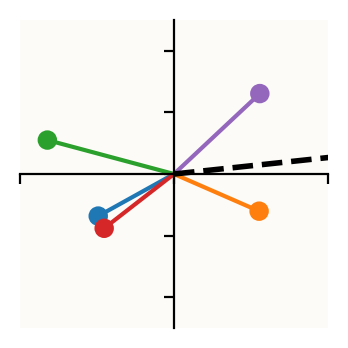

un


In [25]:
out, acts = get_activation_from_word("un")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

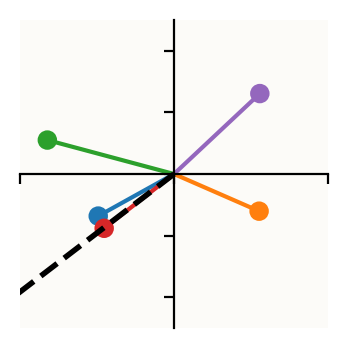

ing


In [26]:
out, acts = get_activation_from_word("ing")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

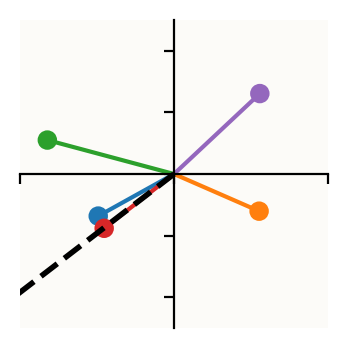

tion


In [27]:
out, acts = get_activation_from_word("tion")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])